In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv(r"C:\Users\kolli\OneDrive\Documents\kaggle\train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: >

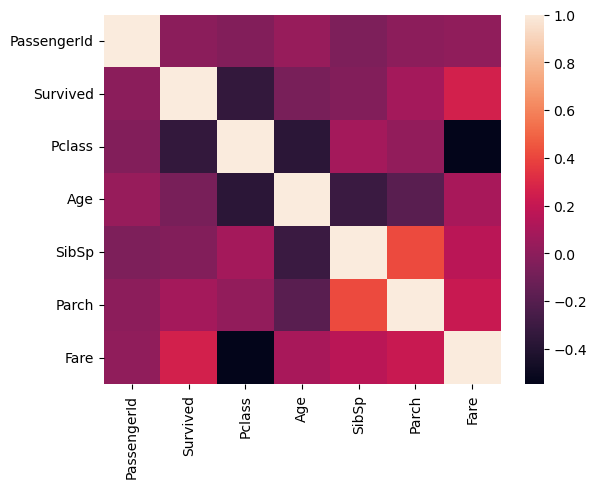

In [6]:
sns.heatmap(data.corr(numeric_only=True))

**Split our dataset to ensure good representation in both the training and test sets.**

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits= 1, test_size=0.2, train_size = 0.8)
for train_indices,test_indices in split.split(data,data[['Survived','Sex','Pclass']]):
    train = data.loc[train_indices]
    test = data.loc[test_indices]

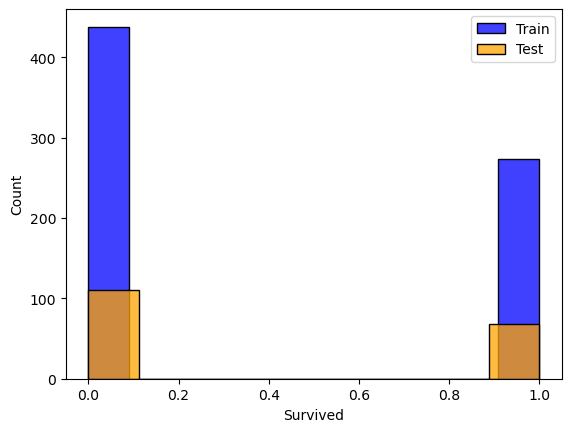

In [8]:
sns.histplot(train['Survived'], color='blue', label='Train')
sns.histplot(test['Survived'], color='orange', label='Test')
plt.legend()
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 767 to 801
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          564 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        156 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


**Find some features to drop (some of them would be encoded)**

In [10]:
to_drop=['PassengerId','Name', 'Sex','Ticket','Embarked','Cabin']

**Pipeline**

In [11]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [12]:
class Imputer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        imputer = SimpleImputer(strategy='most_frequent')
        X['Age'] = imputer.fit_transform(X[['Age']])
        X['Embarked'] = imputer.fit_transform(X[['Embarked']]).ravel() 
        return X

In [13]:
class Encoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        embarked = ['S', 'C', 'Q']
        sex = ['male','female']

        for emb in embarked:
            X[emb] = pd.Series(X['Embarked'] == emb).astype('int64')
        for s in sex:
            X[s] = pd.Series(X['Sex'] == s).astype('int64')
        return X

In [14]:
class FeatureDropper(BaseEstimator,TransformerMixin):

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        return X.drop(columns=to_drop,errors='ignore')

In [15]:
from sklearn.pipeline import Pipeline

ppl = Pipeline([('imputer',Imputer()),
                ('encoding',Encoder()),
                ('dropper',FeatureDropper()),
               ('scaler',StandardScaler())])

**Prepare Train data**

In [16]:
X_train,y_train = train.drop('Survived',axis=1),train['Survived']

In [17]:
X_train = ppl.fit_transform(X_train)

**Random Forest Model**

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [{
    'n_estimators': [150,200,500], 
    'max_depth': [None,2,3], 
    'min_samples_split': [2,3,4],
}]

grid_cv = GridSearchCV(clf,param_grid,cv = 3,scoring='accuracy')
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 2, 3],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [150, 200, 500]}],
             scoring='accuracy')

In [19]:
grid_cv.best_params_

{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 200}

In [20]:
clf_rf = grid_cv.best_estimator_

In [21]:
from sklearn.metrics import classification_report
X_test,y_test = test.drop('Survived',axis=1),test['Survived']
X_test = ppl.fit_transform(X_test)

In [22]:
print(classification_report(y_test,clf_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       111
           1       0.81      0.65      0.72        68

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.80       179



In [23]:
clf_rf.score(X_test,y_test)

0.8100558659217877

**Linear SVC Model**

In [24]:
from sklearn.svm import LinearSVC
clf_svc = LinearSVC()

param_grid = [{
    'C': [0.001,0.01, 0.1, 1, 10,100], 
    'max_iter': [1000, 2000, 3000]
}]

grid_cv_lsvc = GridSearchCV(clf_svc,param_grid,cv=4,scoring='accuracy')
grid_cv_lsvc.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=LinearSVC(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [1000, 2000, 3000]}],
             scoring='accuracy')

In [25]:
clf_svc = grid_cv_lsvc.best_estimator_

In [26]:
print(classification_report(y_test,clf_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       111
           1       0.76      0.71      0.73        68

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [27]:
clf_svc.score(X_test,y_test)

0.8044692737430168

In [28]:
best_model=clf_rf

**Fitting our best model on the whole train dataset before predicting test results**

In [29]:
full_X_train,full_Y_train = data.drop('Survived',axis=1),data['Survived']
full_X_train = ppl.fit_transform(full_X_train)
best_model = best_model.fit(full_X_train,full_Y_train)

**Read Test Data**

In [31]:
test_data = pd.read_csv(r"C:\Users\kolli\OneDrive\Documents\kaggle\test.csv")

**There is a NaN in the 'Fare' column in the test_data, so we will fill it with pandas methods**

In [32]:
test_data['Fare']=test_data['Fare'].fillna(test_data['Fare'].mean())

**Get submission**

In [42]:
import pandas as pd

test_data = pd.read_csv(r"C:\Users\kolli\OneDrive\Documents\kaggle\test.csv")

# Fill missing Fare values
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

# Save PassengerId before transformation
ids = pd.DataFrame(test_data['PassengerId'])

# Transform features
test_data = ppl.fit_transform(test_data)

# Predict
y_preds = best_model.predict(test_data)
y_preds = y_preds.reshape(-1, 1)

# Add predictions to PassengerId DataFrame
ids['Survived'] = y_preds

# Save to Excel (.xlsx format)
ids.to_excel(r"C:\Users\kolli\OneDrive\Documents\kaggle\KAGGLEsubmission.xlsx", index=False)
